**Materia: Visión por Computadora 1**

Alumno: Ezequiel Alejandro Caamaño

Cohorte: 18va.

Trabajo Práctico Nro. 2

Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
Opcional:
1. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure
operators in shapefrom focus.
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

In [15]:

!pip install opencv-python numpy matplotlib


In [16]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def sharpness_fft(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return np.mean(magnitude_spectrum)

def sharpness_tenengrad(image):
    sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    magnitude = np.sqrt(sobelX**2 + sobelY**2)
    return np.mean(magnitude)


In [17]:

video_path = 'images/focus_video.mov'
cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), "No se pudo abrir el video"

frames = []
fft_all, fft_roi, tenengrad_all = [], [], []
fft_grids = { (3,3): [], (5,5): [], (7,5): [] }

while True:
    ret, frame = cap.read()
    if not ret: break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    frames.append(frame)

    # FFT Global
    fft_all.append(sharpness_fft(gray))

    # ROI Central (10% del área)
    roi = gray[h//2 - h//20 : h//2 + h//20, w//2 - w//20 : w//2 + w//20]
    fft_roi.append(sharpness_fft(roi))

    # Tenengrad Global
    tenengrad_all.append(sharpness_tenengrad(gray))

    # FFT Grid NxM
    for (nx, ny) in fft_grids.keys():
        score = 0
        for i in range(nx):
            for j in range(ny):
                x1 = int(i * w / nx)
                x2 = int((i + 1) * w / nx)
                y1 = int(j * h / ny)
                y2 = int((j + 1) * h / ny)
                cell = gray[y1:y2, x1:x2]
                score += sharpness_fft(cell)
        fft_grids[(nx,ny)].append(score / (nx * ny))

cap.release()
print("Video procesado")


Video procesado


In [18]:
def show_frame(title, frame, maxframe):
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(title+ f" (Frame {maxframe})")
    plt.axis('off')
    plt.show()


/var/folders/tl/xglkhb5171d5q1w_9pqd1ldr0000gp/T/ipykernel_86261/142453348.py:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()


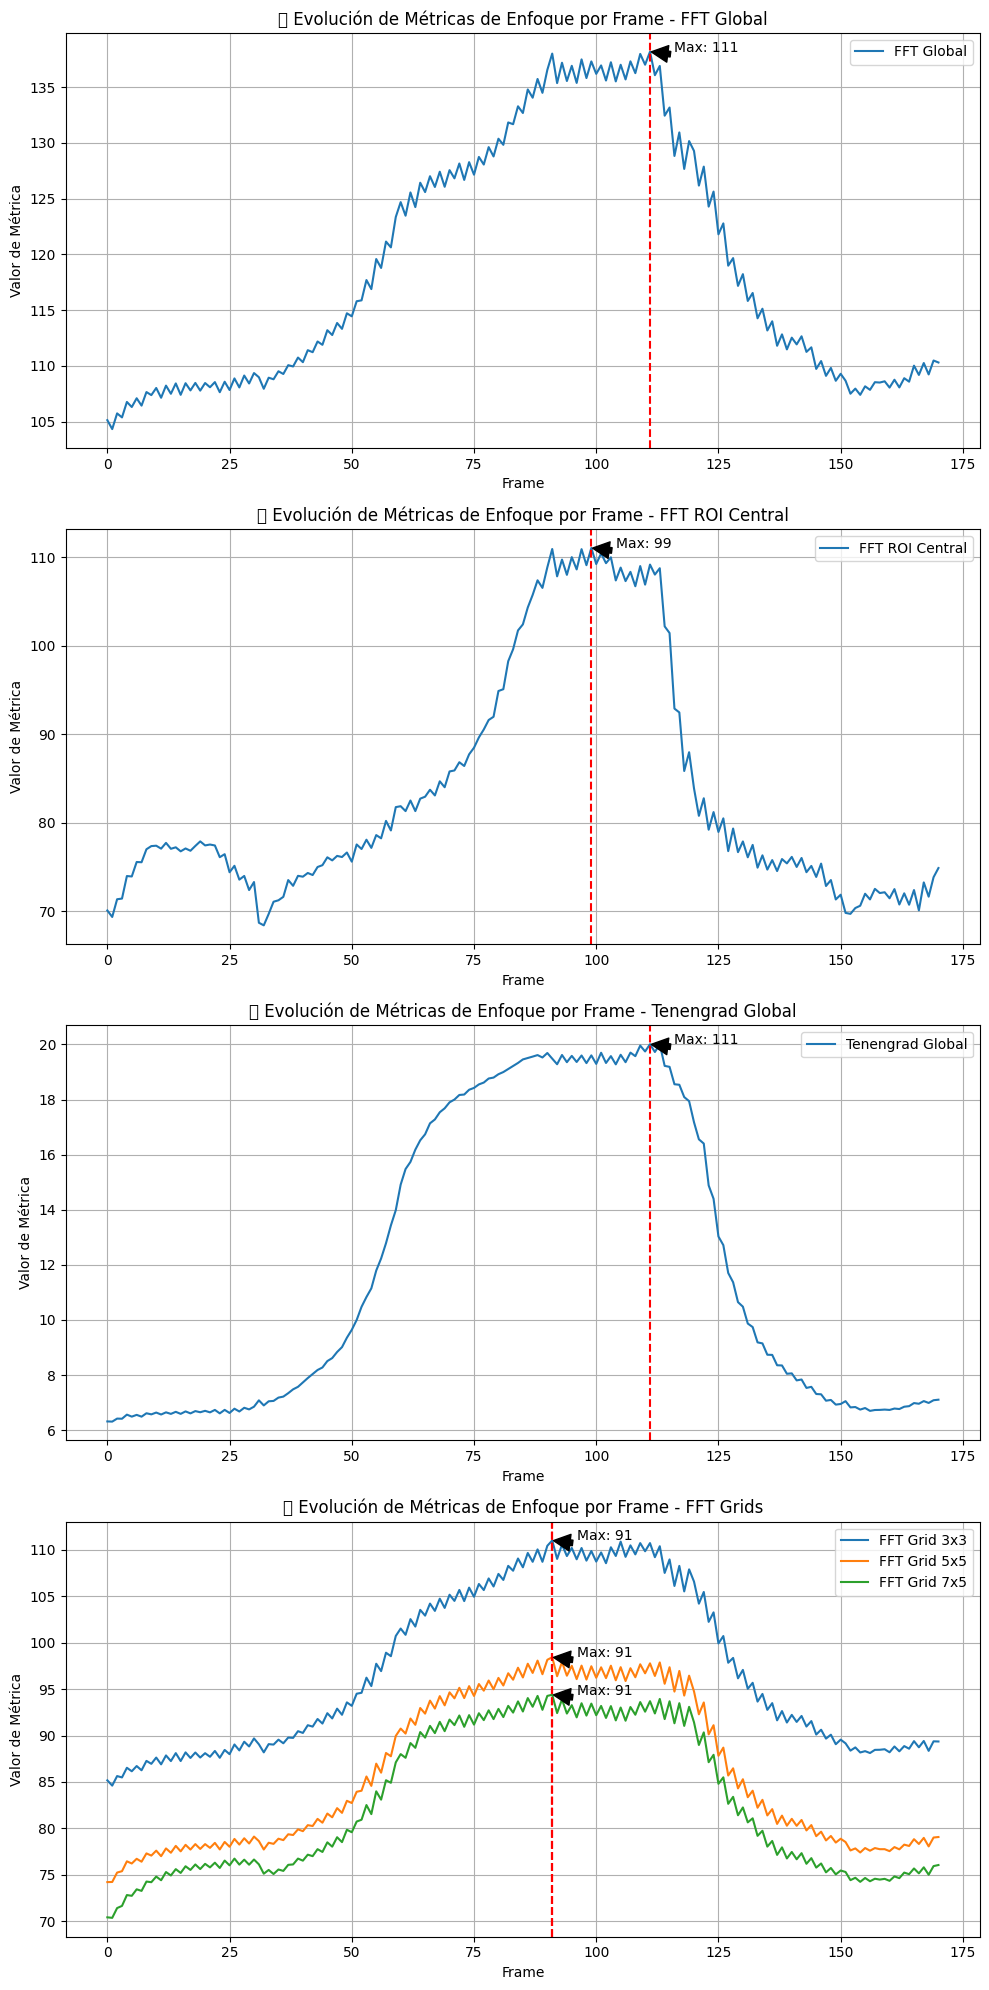

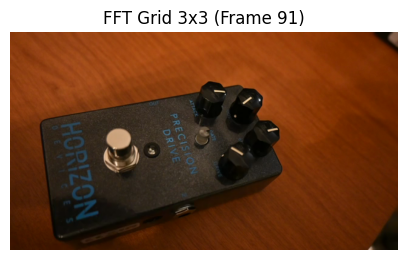

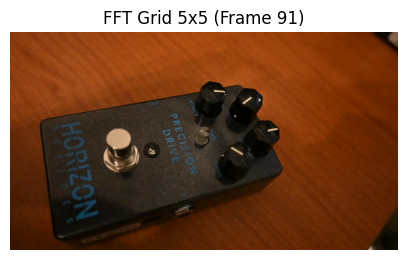

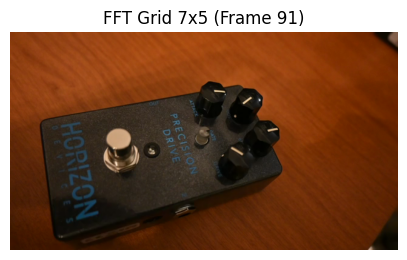

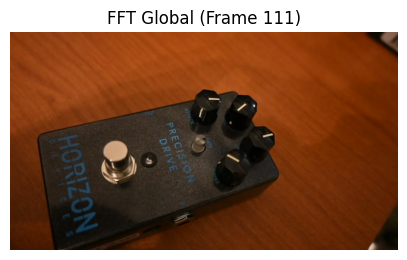

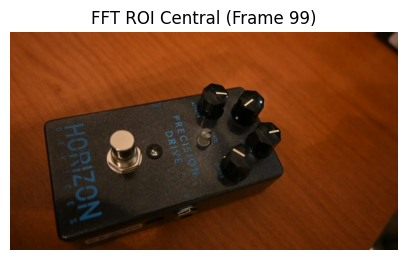

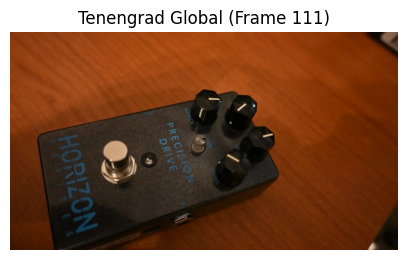

In [19]:

import matplotlib.pyplot as plt

# Crear una figura con subgráficos
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Graficar FFT Global
axs[0].plot(fft_all, label='FFT Global')
max_fft_global_frame = np.argmax(fft_all)
axs[0].axvline(max_fft_global_frame, color='r', linestyle='--')
axs[0].annotate(f'Max: {max_fft_global_frame}', xy=(max_fft_global_frame, fft_all[max_fft_global_frame]), xytext=(max_fft_global_frame + 5, fft_all[max_fft_global_frame]),
                arrowprops=dict(facecolor='black', shrink=0.05))
axs[0].set_title('📈 Evolución de Métricas de Enfoque por Frame - FFT Global')
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Valor de Métrica')
axs[0].legend()
axs[0].grid(True)

# Graficar FFT ROI Central
axs[1].plot(fft_roi, label='FFT ROI Central')
max_fft_roi_frame = np.argmax(fft_roi)
axs[1].axvline(max_fft_roi_frame, color='r', linestyle='--')
axs[1].annotate(f'Max: {max_fft_roi_frame}', xy=(max_fft_roi_frame, fft_roi[max_fft_roi_frame]), xytext=(max_fft_roi_frame + 5, fft_roi[max_fft_roi_frame]),
                arrowprops=dict(facecolor='black', shrink=0.05))
axs[1].set_title('📈 Evolución de Métricas de Enfoque por Frame - FFT ROI Central')
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Valor de Métrica')
axs[1].legend()
axs[1].grid(True)

# Graficar Tenengrad Global
axs[2].plot(tenengrad_all, label='Tenengrad Global')
max_tenengrad_frame = np.argmax(tenengrad_all)
axs[2].axvline(max_tenengrad_frame, color='r', linestyle='--')
axs[2].annotate(f'Max: {max_tenengrad_frame}', xy=(max_tenengrad_frame, tenengrad_all[max_tenengrad_frame]), xytext=(max_tenengrad_frame + 5, tenengrad_all[max_tenengrad_frame]),
                arrowprops=dict(facecolor='black', shrink=0.05))
axs[2].set_title('📈 Evolución de Métricas de Enfoque por Frame - Tenengrad Global')
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Valor de Métrica')
axs[2].legend()
axs[2].grid(True)

# Graficar FFT Grids
for i, (key, values) in enumerate(fft_grids.items()):
    axs[3].plot(values, label=f'FFT Grid {key[0]}x{key[1]}')
    max_grid_frame = np.argmax(values)
    axs[3].axvline(max_grid_frame, color='r', linestyle='--')
    axs[3].annotate(f'Max: {max_grid_frame}', xy=(max_grid_frame, values[max_grid_frame]), xytext=(max_grid_frame + 5, values[max_grid_frame]),
                    arrowprops=dict(facecolor='black', shrink=0.05))

axs[3].set_title('📈 Evolución de Métricas de Enfoque por Frame - FFT Grids')
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Valor de Métrica')
axs[3].legend()
axs[3].grid(True)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()


# Identificar y mostrar los frames de mayor enfoque para cada métrica
max_fft_global_frame = np.argmax(fft_all)
max_fft_roi_frame = np.argmax(fft_roi)
max_tenengrad_frame = np.argmax(tenengrad_all)

for key, values in fft_grids.items():
    max_grid_frame = np.argmax(values)
    show_frame(f"FFT Grid {key[0]}x{key[1]}", frames[max_grid_frame], max_grid_frame)

show_frame("FFT Global", frames[max_fft_global_frame], max_fft_global_frame)
show_frame("FFT ROI Central", frames[max_fft_roi_frame], max_fft_roi_frame)
show_frame("Tenengrad Global", frames[max_tenengrad_frame], max_tenengrad_frame)

*Extra: Agregamos uso de Unsharp Masking y comparamos las curvas*

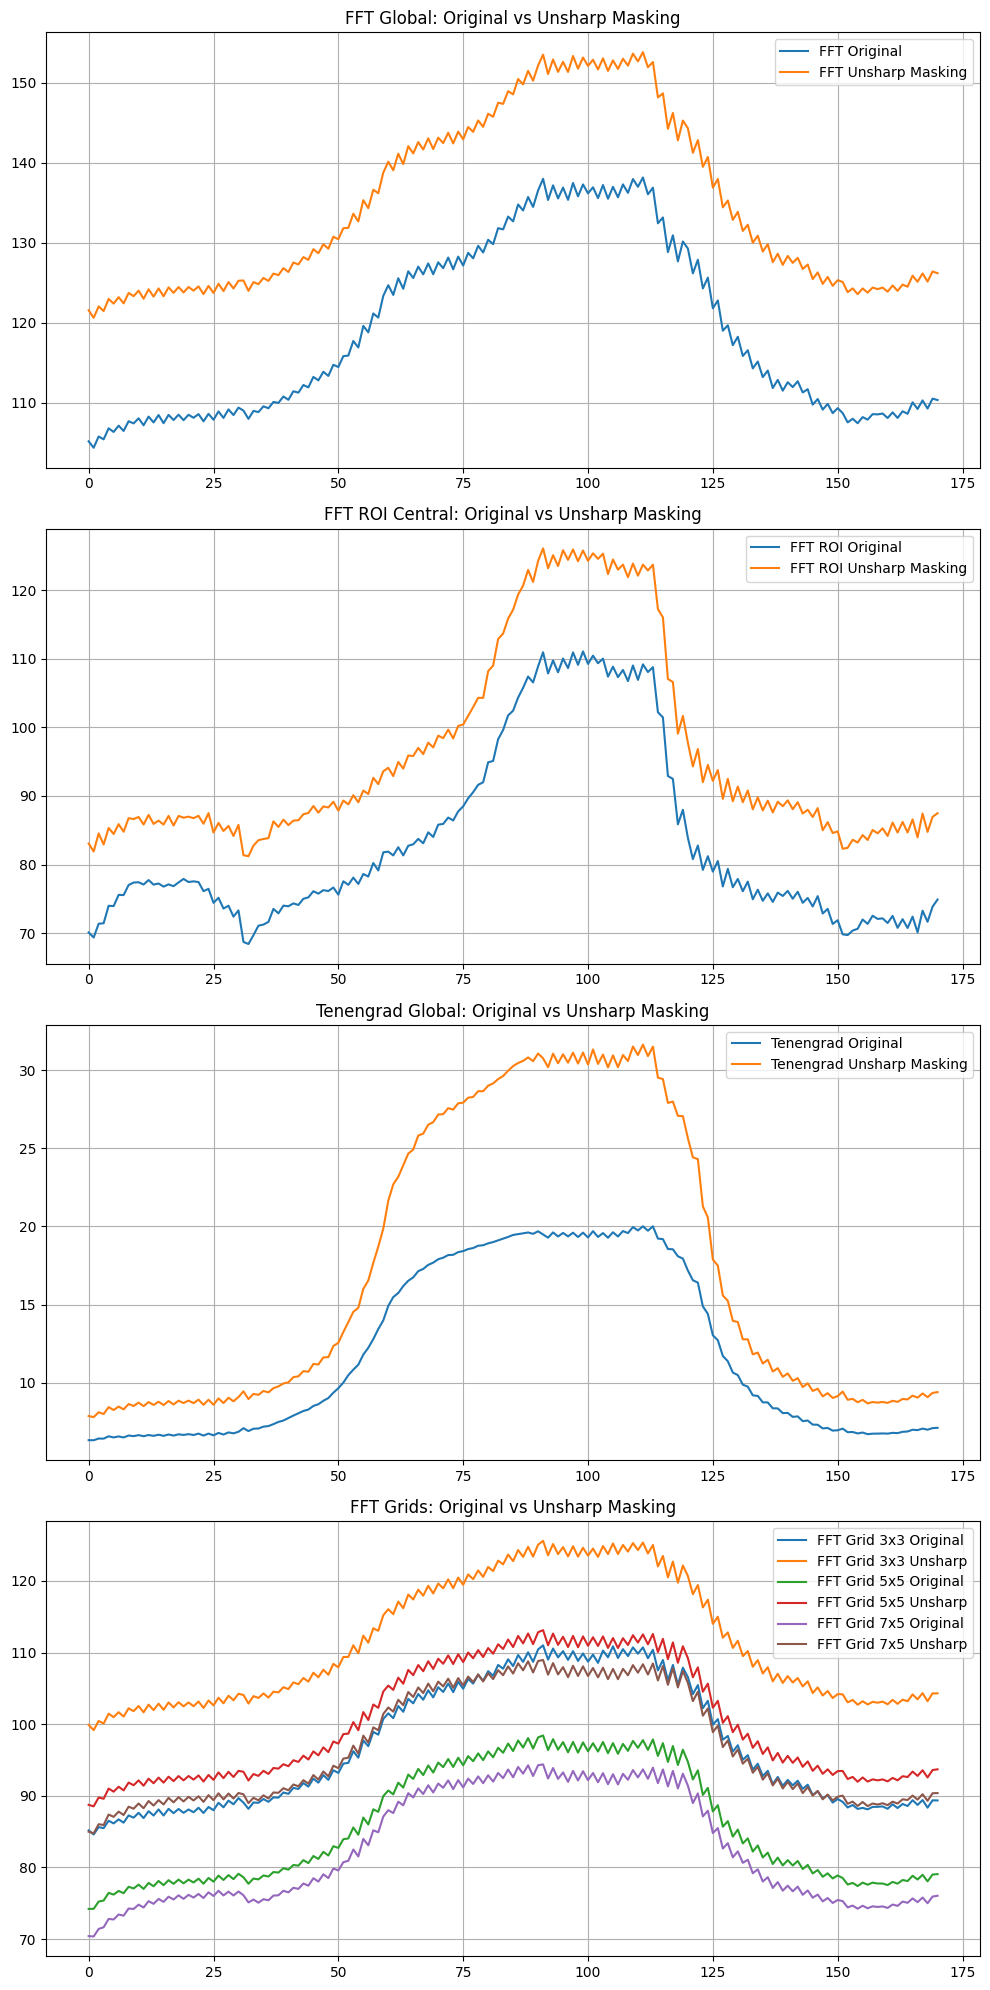

In [20]:
# Parámetros de Unsharp Masking
sigma = 1.0          # Desviación estándar de la Gaussian blur
amount = 1.5         # Factor de realce
threshold = 0       # Umbral de diferencia (0 = sin umbral)

# Función que aplica unsharp masking a una imagen en escala de grises
def unsharp_mask(gray, sigma=1.0, amount=1.5, threshold=0):
    blurred = cv2.GaussianBlur(gray, (0, 0), sigma)
    sharpened = cv2.addWeighted(gray, 1 + amount, blurred, -amount, 0)
    if threshold > 0:
        low_contrast_mask = np.abs(sharpened - gray) < threshold
        sharpened[low_contrast_mask] = gray[low_contrast_mask]
    return sharpened

# Recalcular métricas sobre la imagen unsharp‑masked
fft_all_usm, fft_roi_usm, tenengrad_all_usm = [], [], []
fft_grids_usm = { (3,3): [], (5,5): [], (7,5): [] }

for frame in frames:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_usm = unsharp_mask(gray, sigma, amount, threshold)

    # FFT Global
    fft_all_usm.append(sharpness_fft(gray_usm))

    # ROI Central (10% del área)
    h, w = gray_usm.shape
    roi_usm = gray_usm[h//2 - h//20 : h//2 + h//20, w//2 - w//20 : w//2 + w//20]
    fft_roi_usm.append(sharpness_fft(roi_usm))

    # Tenengrad Global
    tenengrad_all_usm.append(sharpness_tenengrad(gray_usm))

    # FFT Grid NxM
    for (nx, ny) in fft_grids_usm.keys():
        score = 0
        for i in range(nx):
            for j in range(ny):
                x1 = int(i * w / nx)
                x2 = int((i + 1) * w / nx)
                y1 = int(j * h / ny)
                y2 = int((j + 1) * h / ny)
                cell = gray_usm[y1:y2, x1:x2]
                score += sharpness_fft(cell)
        fft_grids_usm[(nx,ny)].append(score / (nx * ny))

# Visualizar diferencias entre métricas originales y con Unsharp Masking
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# FFT Global
axs[0].plot(fft_all, label='FFT Original')
axs[0].plot(fft_all_usm, label='FFT Unsharp Masking')
axs[0].set_title('FFT Global: Original vs Unsharp Masking')
axs[0].legend(); axs[0].grid(True)

# FFT ROI Central
axs[1].plot(fft_roi, label='FFT ROI Original')
axs[1].plot(fft_roi_usm, label='FFT ROI Unsharp Masking')
axs[1].set_title('FFT ROI Central: Original vs Unsharp Masking')
axs[1].legend(); axs[1].grid(True)

# Tenengrad Global
axs[2].plot(tenengrad_all, label='Tenengrad Original')
axs[2].plot(tenengrad_all_usm, label='Tenengrad Unsharp Masking')
axs[2].set_title('Tenengrad Global: Original vs Unsharp Masking')
axs[2].legend(); axs[2].grid(True)

# FFT Grids
for i, (key, values) in enumerate(fft_grids.items()):
    axs[3].plot(values, label=f'FFT Grid {key[0]}x{key[1]} Original')
    axs[3].plot(fft_grids_usm[key], label=f'FFT Grid {key[0]}x{key[1]} Unsharp')
axs[3].set_title('FFT Grids: Original vs Unsharp Masking')
axs[3].legend(); axs[3].grid(True)

plt.tight_layout()
plt.show()